# Elizabeth Daly
# HDip Data Analytics 2020
## Machine Learning & Statistics Project
***

For the module project we must create a web service that uses machine learning to make predictions of wind turbine power output from wind speed values. The web service should respond with predicted power values based on wind speed values sent as HTTP requests. A Dockerfile will be used to build and run the web service in a container. 

The very first thing to do is to import required packages.

In [1]:
# For data frames.
import pandas as pd

# For numerical arrays.
import numpy as np

# For plotting
import matplotlib.pyplot as plt

#For maths
import math as m

# Might use this
import seaborn as sns

# For 
from sklearn import linear_model

# For 
from sklearn.metrics import mean_squared_error, r2_score

# For 
from sklearn.preprocessing import PolynomialFeatures

# For 
from sklearn.model_selection import train_test_split

# For 
from sklearn.pipeline import Pipeline

# For support vector machine regression
from sklearn.svm import SVR

## Data exploration
Reference <span style='color:red'> [1 Geron] </span> suggests a number of steps to follow when beginning a new machine learning project. The very first is to get the data and explore it, so now I'll import the **powerproduction** dataset provided and have a look at it. I'll also keep an intact copy of the original dataset in a dataframe called dforig. 

In [2]:
# File provided as a txt file. I saved it as a csv file.
df = pd.read_csv("data\powerproduction.csv")

# Make a copy of the original dataset in case we need it later.
dforig = df

# Size?
shape = df.shape
print("Data frame shape", shape, "r,c")

# Check for NaNs, missing values etc
print(df.count())

Data frame shape (500, 2) r,c
speed    500
power    500
dtype: int64


In [3]:
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The raw data contains a column of wind speed values (in increasing order of wind speed) and a column of associated power values. Looks like the first and last 5 lines contain zeros for power. Is this just a fluke? There's probably a reason for it: one can't generate power with low wind speeds and perhaps one can't operate the turbines at very high wind speeds? Check by printing more of the head of file. No units have been provided with the data, so I will assume units of wind speed are (m/s), and those of power are kilowatts (kW), as that's what seems to make sense for these numbers.

In [4]:
df.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [5]:
# Look at some quick descriptive statistics of the numeric data.
print(df.describe())

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6.324750    5.288000
50%     12.550500   41.645500
75%     18.775250   93.537000
max     25.000000  113.556000


Look at the distribution of wind speeds. Why? Our assignment in the Programming for Data Analysis module involved looking at the numpy.random package <span style='color:red'> [2 np random]</span>. I learned that, under certain conditions, wind speed has a Rayleigh distribution, which is not symmetrical. I wonder if the samples in our dataset follow a such distribution? The mean and variance of this distribution are calculated from the scale factor: $\mu = \sqrt{\pi / 2} s$ and $\sigma^2 = (4 - \pi)/2 s^2$. This results in $\mu \approx 1.25 s$ and $\sigma^2 \approx 0.43 s$. From the descriptive statistics above we know that the mean wind speed is 12.6 m/s, so the scale factor to use is $s = \mu/1.25 \approx 10$.

Average wind speed is 12.59 m/s


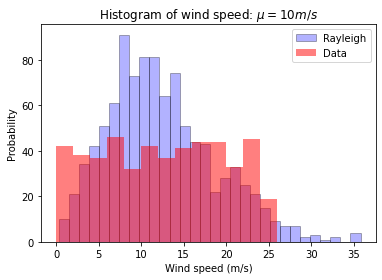

In [6]:
# Wind speeds sampled from a Rayleigh distribution, mean=12.6 m/s
# Default: numpy.random.rayleigh(scale=1.0, size=None)
data = np.random.rayleigh(10, 1000) 
plt.hist(data, bins=30, alpha = 0.3, facecolor='blue', edgecolor='black', label=['Rayleigh'])

bins = np.arange(0, 30, 2) # fixed bin size
plt.hist(df['speed'], bins=bins, alpha=0.5, facecolor='red', label=['Data'])

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Probability')
plt.title('Histogram of wind speed: $\mu=10 m/s$')
plt.legend()
w = df['speed'].mean(axis=0)
print(f'Average wind speed is {w:.2f} m/s')

Well, that was a dead end. Clearly the wind speeds provided do not follow a Rayleigh distribution, rather roughly a uniform distribution.

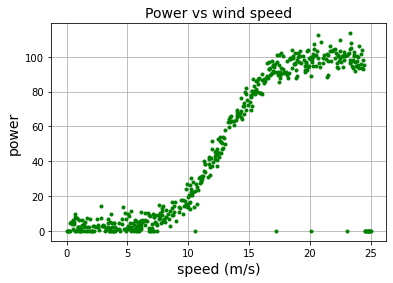

In [7]:
# Try plotting power as a function of wind speed to check for any obvious relationship between them.
plt.plot(df['speed'], df['power'],  '.g')
plt.title('Power vs wind speed', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.grid()

Clearly there isn't a simple relationship between power and speed. It looks as if little power is generated until some threshold speed is achieved (about 7 m/s), then it increases nearly linearly in a range of wind speeds (10 - 15 m/s), before saturating above a certain wind speed (about 17 m/s). The plot would suggest there is a range of wind speeds where the power seems to increase linearly with wind speed, but we need to consider a model that works outside of this range also. Apart from the zero power values at the top and bottom (more here) of the dataset, there are very occasional zero values for power above about 10 m/s; to me they just look like anomalies.

### What do we expect?
Is this the curve we should expect? I think so. The theoretical power curve for a turbine is specific to each turbine and site; see Figure 2 in <span style='color:red'> [3 WT curve] </span>. I'll include a screengrab here. On the figure:
- The cut-in speed is the threshold wind speed that much be reached before the turbine will start to generate electricity. A typical value is about 3 m/s.
- The rated output power is achieved at approximately 12 - 13 m/s.
- The cut-out speed is the wind speed at which the turbine will stop producing electricity in order to avoid damage; typically 25 m/s.

<img src="img/P-wind-theory.JPG" height=500 width=500>

How is this theoretical curve calculated? I found some formulae which state that the extractable power from the wind is given by:
$$P = \frac{1}{2} \rho A v^3 C_p$$
where $\rho$ is the density of air, $A$ is the area swept by the turbines, $v$ is the wind speed, and $C_p$ is the power coefficient <span style='color:red'> [4 WT calc] </span>. Looking at this formula I would expect power to depend on $v^3$. However, $C_p$ is not static as it depends on the ratio of blade tip speed to wind speed (called $\lambda$). That function looks like this:

<img src="img/Cp-lambda.JPG">

Average wind speed in data is 12.59 m/s


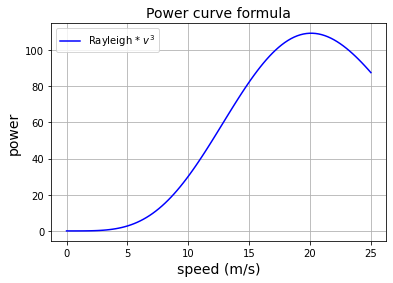

In [8]:
# So I would expect the power curve to be a product of $v^3$ and this bump above. I'll try to model it.
# wind speed
x = np.linspace(0, 25, 100)

# speed ^3
v = np.power(x, 3)

# Try a Rayeigh distribution for the power coefficient, need scale factor sc.
# w = mean wind speed from our dataset above
print(f'Average wind speed in data is {w:.2f} m/s')

sc = w / (m.sqrt((m.pi) / 2)) # mode or scale
ray = lambda s, x: (x / s ** 2) * ( np.exp( (-x **2) / (2 * s **2) )  )

# PLot the product v^3 * Rayleigh and scale it down.
plt.plot(x, 0.5 * ray(sc, x)*v, color='b', label='Rayleigh * $v^3$')
plt.title('Power curve formula', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power', fontsize='14')
plt.legend()
plt.grid()

 So this is starting to look like our data but I feel it would be difficult to model. I might start with something simpler.

## Data preparation
The next step in a project is to prepare the dataset <span style='color:red'> [1 Geron] </span>. The first thing I'll do is clean it by removing unwanted zeros. The easiest approach would be to remove all rows where power = 0. I don't really want to do that however, because I feel like the zero power values below about 10 m/s are part of the data, while the ones above about 24 m/s represent some sort of a limit of operation. I can't see how a model would be able to abruptly predict power = 0 at the very high end of speed values unless I hard coded it in as a condition, or constrained the allowed input speed values to a range. I might come back to this here, or place a limit on wind speed input values in the front end of the application.
Other steps which could happen now include feature selection and feature scaling. Feature selection is used to drop inputs that provide no useful information; in our case we have only one input (speed) so that step isn't relevant. Feature scaling would be necessary if the scale of an input feature was very big or small compared to other features; again, not relevant here. 

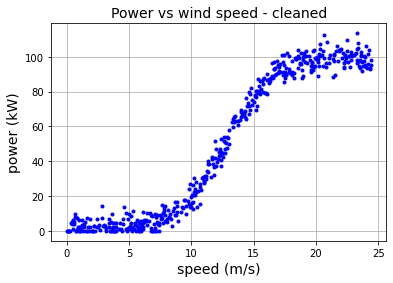

In [9]:
# Where do all the zeros occur?
dfz = df[df["power"] == 0]
# print(f'There are {dfz.shape} zero values for power')
# print(dfz)

# Want to keep all rows with power != 0 iff speed > 10
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
dfc = df.loc[(df.power == 0) & (df.speed > 10)] # indices where this is true
dfc # check 14 rows
# I want to remove these rows from my existing dataset.
df.drop(df.loc[(df.power == 0) & (df.speed > 10)].index, inplace=True)

plt.plot(df['speed'], df['power'],  '.b')
plt.title('Power vs wind speed - cleaned', fontsize='14')
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.grid()

## Identify promising models
<span style='color:red'> [1 Geron] </span> now suggests shortlisting promising models. I'll have to think about it. This is a supervised learning problem because we have been provided with a training set which is labeled: we know the power output for each value of input wind speed. Furthermore, it is a regression problem because we have been asked to predict a target numeric value of power given an input wind speed. This is different to classification, where one would be asked to predict what class a particular input belongs to; for example, using the iris data set predict iris species using some/all of the inputs petal length, petal width, sepal length, and sepal width. Some supervised learning algorithms suitable for our task include linear regression, neural networks, and maybe some like Support Vector Machine (SVM) regression and decision trees. I'll probably try the first two and only do more if I have time.

<span style='color:red'> [CourseML] </span> for some of these.

***
### Model 1: Linear Regression
Looking at the data, we could probably get away with fitting a straight line to it. That would likely do a very good job of predicting output power over a certain range of input wind speeds (around 10 - 15 m/s). However, it wouldn't do a great job around the places where the power is rising more slowly (< 10 m/s) or where it is leveling off (> 15 m/s). I think I'll start with a linear model and maybe move on to nonlinear regression afterwards. 

In [10]:
# Take a quick look at the correlation between the dataframe columns
df.corr()

,speed,power
speed,1.000000,0.950026
power,0.950026,1.000000


<span style='color:red'> [Medium nlr] </span> states that a correlation coefficient > 0.7 suggests a strong linear tendency and a nonlinear model would be inappropriate. We see values > 0.9 for the correlation between power and speed, so a straight line might actually be fine. We'll see.

(486, 1)
(486,)
Coefficients: 
 [5.5509909]
Mean squared error: 166.62
Coefficient of determination: 0.90


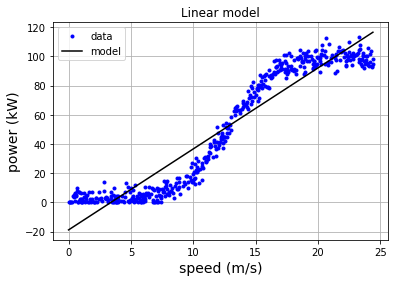

In [11]:
# From: https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares
# and example from
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

# Create linear regression object
reg = linear_model.LinearRegression()

# Need x and y in correct format TO DO restrict x values to be 7-18 & reflect that in front-end that calls model
X = df[["speed"]] # note dimensions
y = df["power"]

print(X.shape)
print(y.shape)

# Split into training and test sets TO DO

# Train the model using the training sets
reg.fit(X, y)

# Make predictions using the testing set
y_pred = reg.predict(X)

# The coefficients
print('Coefficients: \n', reg.coef_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y, y_pred))

# Inspect the fit
plt.plot(df['speed'], df['power'],  '.b', label="data")
plt.plot(df['speed'], y_pred, 'k-', label="model")
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Linear model")
plt.grid()
plt.legend()

This is an example of *underfitting*, where the model is too simple to learn the structure of the data: a straight line is not a good fit to our data. One solution is to pick a more powerful model which has more parameters, so we will now try fitting a polynomial to our data. There are many possible nonlinear models <span style='color:red'> [5 Medium nlr] </span>. However, as we already know that $ power \propto speed^3$, a third order polynomial might be a good place to start.

First, I'll split the data set into a training and validation part (what we have been calling test) and look at the linear model as a function of training set size. The code that follows is taken directly from <span style='color:red'> [1 Geron] </span> (p. 132) with just some edits specific to this notebook. The plot below shows that the straight line is a good fit to the data (close to zero error) when there are only a few data points in the training set, but when more points are added to the training set, the error increases because a straight line is not a good fit to this data at all. The training error reaches a plateau. On the validation or test set, the model (having being trained on only a few training points) cannot generalize well at all to new data and the error is high. As more points are added to the training set, the model performs better and the validation error comes down, although it too tends towards the same limit. This learning curve is typical of a model that is underfitting. Adding more data will not help to bring down the error, but choosing a more complex model might <span style='color:red'> [6 CourseML] </span> (Week 6 lectures).

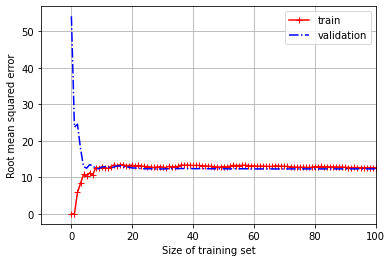

In [12]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", label="train")
    plt.plot(np.sqrt(val_errors), "b-.", label="validation")
    plt.legend()
    plt.xlabel("Size of training set")
    plt.ylabel("Root mean squared error")
    plt.grid()
    plt.xlim(-10, 100)

lin_reg = linear_model.LinearRegression()
plot_learning_curves(lin_reg, X, y)

***
### Model 2: Polynomial Regression

We transform the our simple linear model $$y = \theta_0 + \theta_1 x $$ into a nonlinear one $$ y = \theta_0 + \theta_1 (x) + \theta_2 (x^2) + \theta_3 (x^3)$$ We can still do linear regression using this model because it is linear in the model parameters $\theta$: $\theta_0$ is the bias term (intercept in a straight line) and the remaining $\theta$ terms are feature weights. <span style='color:red'> [7 Medium polyReg] </span>. The $x$, $x^2$, and $x^3$ are our features, which we obtain by transforming the data we were given. We use the PolynomialFeatures class in Scikit-learn to do this by adding the square and cube of our data to create two new features <span style='color:red'> [1 Geron] </span> (p. 129). 

In [13]:
# Try polynomial order 3
poly_features = PolynomialFeatures(degree=3, include_bias=False) #include_bias -> intercept

# Split the data set into train/set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Generate the new features (powers of x) for the training data
X_train_poly = poly_features.fit_transform(X_train)

# Create an instance of the model & train it using the transformed training set.
regP = linear_model.LinearRegression()
regP.fit(X_train_poly, y_train)

# Prediction for y using test data?
X_test_poly = poly_features.fit_transform(X_test)
y_predP = regP.predict(X_test_poly)

# The coefficients of the fit.
print('Coefficients: \n', regP.coef_)
# Don't forget about the intercept - I did initially.
print('Intercept: \n', regP.intercept_)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predP))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_predP))

Coefficients: 
 [-9.5690868   1.48661704 -0.0393913 ]
Intercept: 
 13.748201607837188
Mean squared error: 33.11
Coefficient of determination: 0.98


In [14]:
# Inspect the fit - seems to have a y shift of about -13 (I was forgetting y intercept!)
fit = regP.intercept_ + regP.coef_[0]*df['speed'] + regP.coef_[1]*(df['speed']**2) + regP.coef_[2]*(df['speed']**3)

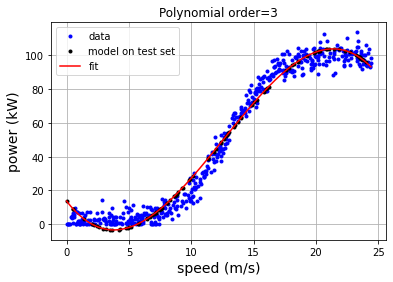

In [15]:
plt.plot(df['speed'], df['power'],  'b.', label="data")
plt.plot(X_test, y_predP, 'k.', label="model on test set")
plt.plot(df['speed'], fit, 'r-', label="fit")
plt.xlabel('speed (m/s)', fontsize='14')
plt.ylabel('power (kW)', fontsize='14')
plt.title("Polynomial order=3")
plt.grid()
plt.legend()

This looks like an excellent fit with an $R^2$ value very close to 1. I'll definitely use it in my final product. I can't plot the test data as a line because the X_test values are randomly selected from the data set so they are not in ascending order - I get a scribble for a curve if I try. I might restrict input values of wind speed in the front end, for example,
- speed < 5, power = 0
- speed > 20, power = take an average of last 20 values in cleaned data set perhaps.

Our model for power output will be:
$$ power = 14.13 - 9.65 speed + 1.48 speed^2 - 0.04 speed^3$$

***
### Model 3: Support Vector Machines

I had come across the support vector machine (SVM) for detection of outliers and for logistic regression, where one is trying to do classification by finding a decision boundary which separates classes. SVM is a large margin classifier as it aims to find a decision boundary which has as large a margin as possible around the decision boundary, i.e, the margin does not contain any training data. SVM outputs a prediction (1 or 0) of whether or not an example belongs to a class, whereas logistic regression outputs a probability. Nonlinear decsion boundries can be tackled though choice of an appropriate kernal in the SVM - I'll explain later. I hadn't realised SVM could be used for regression, but Google tells me it can <span style='color:red'> [8 Medium SVRreg] </span>, so I'll give it a go. SVM regression works in the opposite way to what we have just described: the algorithm tries to fit as many training examples as possible inside the margin while limiting the number that fall outside it <span style='color:red'> [1 Geron] </span> (p. 162).

### SVM kernels
The documentation on SVM in Scikit-learn includes a good basic example of SVM regression performed using different kernels <span style='color:red'> [9 SVR, 10 SKLsvrKer] </span>. The function of the kernel is to transform the input data into the form required for a particular problem <span style='color:red'> [11 DFkernel] </span>. For example, if the decision boundary between two classes is not a simple straight line, one could try using a nonlinear kernel (like polynomial) to better fit the boundary between the classes. As I understand it, this is equivalent to transforming an input feature $x$ to generate polynomial features $x^2, x^3, ..$ as we did above in model 2. </span> (p. 161) It is advisable to try a linear kernel first and then move to the Gaussian radial basis function (RBF) <span style='color:red'> [1 Geron] </span> (p. 161).  This is a good general purpose kernel when there is no prior knowledge about the data <span style='color:red'> [11 DFkernel] </span>. I think the idea of this type of kernel is to compute new features based on the proximity of training examples to landmarks (their similarity), and the simplest thing to do is chose the landmarks to be the training examples themselves <span style='color:red'> [6 CourseML] </span> (Week 7). The Scikit-learn SVM regression algorithm must do this automatically. I'll play around with the various parameters to find a good fit to our data set.

Another thing i see mentioned a lot is that SVMs are sensitive to scaling, so we'll probably have to apply some type of transformation to our input feature before training a model <span style='color:red'> [12 MLMscaler] </span>. 

I will try a linear kernel first and see how we get on. The parameter C is related to regularization: the default value is 1. Small C means lots of regularization, which implies high bias and low variance, or a model that's too simple. Large C means very little regularization, which translates to overfitting as a result of low bias and high variance. I think, regardless of what C I pick below, a linear model will never fit the data.

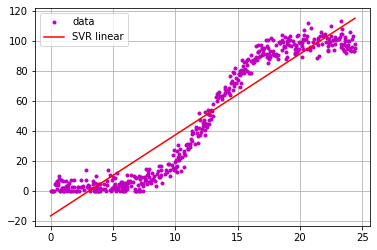

In [16]:
# Create an instance of the SVR class
# C ~1/reg default = 1. Tiny C bad fit, Huge C over fit
svr_lin = SVR(kernel='linear', C=1)

# Want to scale the input values
# https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use
from sklearn.preprocessing import StandardScaler

# Scale X only
sc_X = StandardScaler()
X_scale = sc_X.fit_transform(X)

# Train model with scaled X and y
svr_lin.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_lin.predict(X_scale), '-r', label="SVR linear") # prediction using scaled X data
plt.grid()
plt.legend()

Try a different kernel. Feature x is already scaled and I'll leave C=1. 

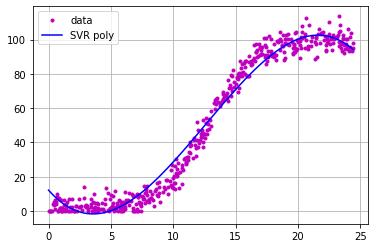

In [17]:
# Create an instance of the SVR class
svr_ply = SVR(kernel="poly", degree=3, coef0=1, C=1, epsilon=0.1, gamma='auto') # OK like poly LR
# coef0 is ..
# epsilon is ..

# Train model with scaled X and y
svr_ply.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_ply.predict(X_scale), '-b', label="SVR poly") # prediction using scaled X data
plt.grid()
plt.legend()

Lastly, try the RBF kernel

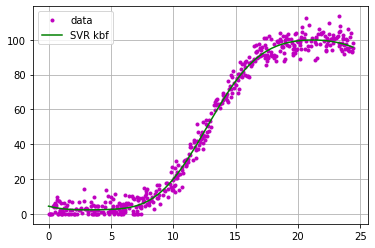

In [18]:
# Create an instance of the SVR class
svr_kbf = SVR(kernel="rbf", C=10, gamma='auto')
# coef0 is ..
# epsilon is ..

# Train model with scaled X and y
svr_kbf.fit(X_scale, y)

# What does the fit look like?
plt.plot(X, y, 'm.', label="data") # X, y data
plt.plot(X, svr_kbf.predict(X_scale), '-g', label="SVR kbf") # prediction using scaled X data
plt.grid()
plt.legend()

In [20]:
# Q. How to predict from a single value? A. Need x and the transformer sc_X
# Scaling issue? As predictions for -1,0,1 seems to match power.
y1 = svr_kbf.predict([[1]])
print(y1)

# Apply same scaler to the x value we want to test.
x2 = 20
x2_scale = sc_X.transform([[x2]])
# Make a prediction for this scaled value - seems sensible.
y2 = svr_kbf.predict(x2_scale)
print(y2)

[98.70666895]
[99.42393008]


Metrics and how parameter values chosen?

https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use
Parameters of the RBF Kernel:
The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

In [ ]:
svm_reg.score(X_scale, y)
# Check setting C=0.01 gives bad score here.

***
### Model 4: Neural Network

## References
<span style='color:red'> [1 Geron] </span> Aurelien Geron, *Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow*, **2019**, 2nd Edition, O'Reilly Media, Inc., CA

<span style='color:red'> [2 np random] </span> numpy.random.rayleigh, NumPy v1.19 Manual, https://numpy.org/doc/stable/reference/random/generated/numpy.random.rayleigh.html

<span style='color:red'> [3 WT curve] </span> Wind Energy Basics, New York Wind Energy Guide for Local Decision Makers, www.nyserda.ny.gov/-/media/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, (Accessed 9 Nov. 2020).

<span style='color:red'> [4 WT calc] </span> Wind Turbine Power Calculations, RWE npower renewables, https://docplayer.net/17802133-Wind-turbine-power-calculations.html, (Accessed 21 Oct. 2020).

<span style='color:red'> [5 Medium nlr] </span> Medium.com, Understanding Non-Linear Regression, https://medium.com/towards-artificial-intelligence/understanding-non-linear-regression-fbef9a396b71 (Accessed 1 Dec. 2020).

<span style='color:red'> [6 CourseML] </span> Andrew Ng, Coursera Machine Learning offered by Stanford, https://www.coursera.org/learn/machine-learning, (Completed & certified Sept. 2020).

<span style='color:red'> [7 Medium polyReg] </span> Medium.com, Polynomial Regression, https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 (Accessed 7 Dec. 2020).

<span style='color:red'> [8 Medium SVRreg] </span> Medium.com, Support Vector Regression in 6 Steps with Python, https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d (Accessed 9 Dec. 2020).

<span style='color:red'> [9 SVR] </span> Scikit-learn, 1.4. Support Vector Machines, https://scikit-learn.org/stable/modules/svm.html#regression (Accessed 12 Dec. 2020).

<span style='color:red'> [10 SKLsvrKer] </span> Scikit-learn, Support Vector Regression (SVR) using linear and non-linear kernels, https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_regression.html (Accessed 12 Dec. 2020).

<span style='color:red'> [11 DFkernel] </span> Data Flair, Kernel Functions-Introduction to SVM Kernel & Examples, https://data-flair.training/blogs/svm-kernel-functions/#:~:text=SVM%20Kernel%20Functions&text=The%20function%20of%20kernel%20is,(RBF)%2C%20and%20sigmoid. (Accessed 12 Dec. 2020).

<span style='color:red'> [12 MLMscaler] </span> Machine Learning Mastery, How to Use StandardScaler and MinMaxScaler Transforms in Python, https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/ (Accessed 12 Dec. 2020).

<span style='color:red'> [13 SVRpractical] </span> Scikit-learn, 1.4.5. Tips on Practical Use, https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use (Accessed 12 Dec. 2020).






<span style='color:red'> [WT FAQ] </span> Wind Turbine FAQ, ENERPOWER Total Energy Solutions, https://enerpower.ie/portfolio/wind-turbine-faq-ireland/, (Accessed 21 Oct. 2020).

<span style='color:red'> [MLM select] </span> Machine Learning Mastery, A Gentle Introduction to Model Selection for Machine Learning, https://machinelearningmastery.com/a-gentle-introduction-to-model-selection-for-machine-learning/ (Accessed 30 Nov. 2020)

Notes:
- describe power curve
- supervised learning as have training set
- feature selection, only one here
- what about feature scaling etc
- algs to use for this problem?
- how to measure perf? Test & validation. 
- all imports into one cell at top when done